In [1]:
from ppo_lr_schedule_2 import PPO, Memory, FClayer, WaveNET, plot, ActorCritic
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym
import gym_Aircraft
import math
import copy

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [2]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
actor_model = torch.load("./Custom_model_fin")
critic_model = torch.load("./Custom_model_fin")
test_model = torch.load("./Custom_model_fin")
mean = np.load('mean_test.npy')
std = np.load('std_test.npy')

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retrieve the o

In [4]:
num_final_nodes = critic_model.fin_fc.in_features
critic_model.fin_fc = nn.Linear(num_final_nodes, 1)

In [5]:
actor_model.fin_fc = nn.Sequential(actor_model.fin_fc, nn.Softmax(dim=-1))
test_model.fin_fc = nn.Sequential(test_model.fin_fc, nn.Softmax(dim=-1))
test_model=test_model.to(device)

In [6]:
for param in actor_model.parameters():
    param.requires_grad = False
    
for param in test_model.parameters():
    param.requires_grad = False

In [7]:
# set angular constants
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

############## Hyperparameters ##############
succeed_coef = 8000         # maximum reward when agent avoids collision
collide_coef = -4000        # reward when agent doesn't avoid collision
change_cmd_penalty = -100   # reward when agent changes command values
cmd_penalty = -0.15          # coefficient of penaly on using command
cmd_suit_coef = -100         # coefficient of suitable command
start_cond_coef = 100       # coefficient of condition on begining

value_tune_epi = 5000

solved_reward = 6000       # stop training if avg_reward > solved_reward
log_interval = 50          # print avg reward in the interval
max_episodes = 50000 + value_tune_epi     # max training episodes
max_timesteps = 300         # max timesteps in one episode
n_latent_var = 60           # number of variables in hidden layer
update_timestep = 2000      # update policy every n timesteps
lr = 0.0001
betas = (0.9, 0.999)
gamma = 0.999                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
step_size = 10000          # lr scheduling step size

# initialize epsilon for greedy algorithm at start
e_start = 1.0               
e_final = 0.001
e_decay = 500
epsilon_by_frame = lambda frame_idx: e_final + (e_start - e_final) * math.exp(-1. * frame_idx / e_decay)
random_seed = 1

# creating environment
experiment_version = 1.29
env_name = "acav-v0"
env = gym.make(env_name)
env.env.__init__(succeed_coef, collide_coef, change_cmd_penalty, cmd_penalty, start_cond_coef, cmd_suit_coef)
render = False

#############################################

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

memory = Memory()
ppo = PPO(actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip, step_size)
# load weight to transfer knowledges
# ppo.policy_old.load_state_dict(torch.load("PPO_1.29.pth"))

# logging variables
running_reward = 0
test_running_reward = 0
avg_length = 0
timestep = 0

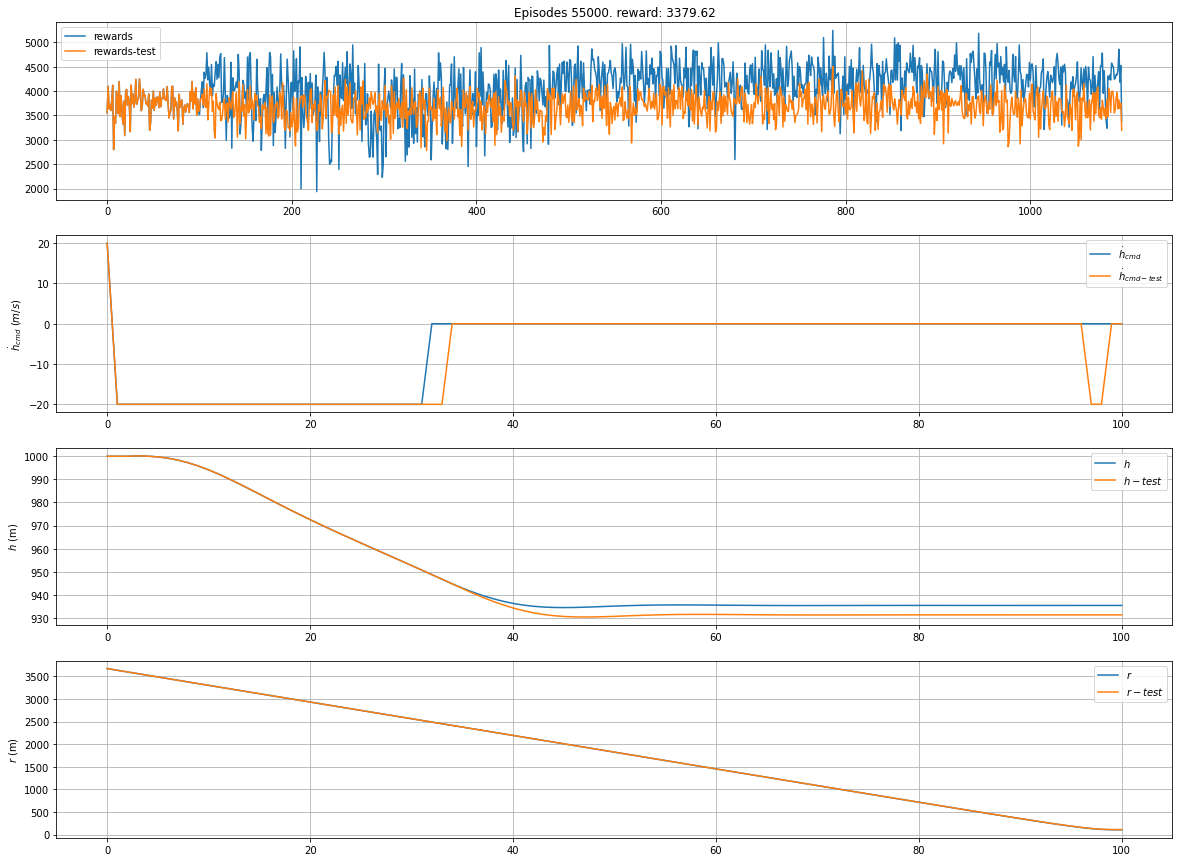

Episode 55000 | avg length: 98.92 | run_reward: 3379.62 | min_r: 106.96 | reward: 6016.0 | init_height_diff: 43.46 


In [8]:
# initialize lists for print
rewards   = []
total_res=[]
test_rewards = []
test_total_res=[]

# training loop
for i_episode in range(1, max_episodes+1):
    epi_reward=0
    test_epi_reward = 0
    
    state = env.reset()
    test_env = copy.deepcopy(env)

    res_list=np.zeros(12)
    test_res_list = np.zeros(12)
    test_done = False
    
    for t in range(max_timesteps):
        timestep += 1
        state = (state-mean)/std
        
        # Test with the initial model
        with torch.no_grad():
            if not test_done:
                if t == 0:
                    test_state = state
                test_action = test_model(torch.from_numpy(test_state).float().to(device)).max(0)[1].item()
                test_state, test_reward, test_done, test_info = test_env.step(test_action)
                test_state = (test_state - mean) / std
                cmd_list, r_list, elev_list, azim_list, Pm_list, Pt_list, h_list, height_diff_list = test_info["info"]
                Pm_list = Pm_list.tolist()
                Pt_list = Pt_list.tolist()
                merged_data = itertools.chain([cmd_list], [r_list], [elev_list], [azim_list], Pm_list, Pt_list, [h_list], [height_diff_list])
                merged_data = np.array(list(merged_data))
                test_res_list = np.vstack([test_res_list,merged_data])
                test_epi_reward += test_reward
                if test_done:
                    test_running_reward += test_epi_reward
                    test_res_list=np.delete(test_res_list,0,0)
                    test_total_res.append(test_res_list)
        
        # select action with model to tune the value network
        if i_episode < value_tune_epi:
            action = ppo.policy_old.act(state, memory, 0)
        else:
            if i_episode == value_tune_epi:
                for param in ppo.policy_old.action_layer.parameters():
                    param.requires_grad = True
                for param in ppo.policy.action_layer.parameters():
                    param.requires_grad = True
            action = ppo.policy_old.act(state, memory, epsilon_by_frame(i_episode - value_tune_epi))
            
        # Running policy_old:    
        state, reward, done, info = env.step(action)
        
        
        # save data to print
        cmd_list, r_list, elev_list, azim_list, Pm_list, Pt_list, h_list, height_diff_list = info["info"]
        Pm_list= Pm_list.tolist()
        Pt_list= Pt_list.tolist()
        merged_data = itertools.chain([cmd_list], [r_list], [elev_list], [azim_list], Pm_list, Pt_list, [h_list], [height_diff_list])
        merged_data = np.array(list(merged_data))
        res_list = np.vstack([res_list,merged_data])

        # Saving reward and is_terminal:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if timestep % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            timestep = 0

        running_reward += reward
        epi_reward += reward
        if render:
            env.render()
        if done:
            res_list=np.delete(res_list,0,0)
            total_res.append(res_list)
            break

    avg_length += t
    
    if i_episode >= value_tune_epi:
        ppo.scheduler.step()

    # stop training if avg_reward > solved_reward
    if running_reward > (log_interval*solved_reward):
        print("########## Solved! ##########")
        torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(experiment_version))
        break

    # logging
    if i_episode % log_interval == 0:
        avg_length = avg_length / log_interval
        running_reward = running_reward / log_interval
        test_running_reward = test_running_reward / log_interval
        rewards.append(running_reward)
        test_rewards.append(test_running_reward)
        plot(i_episode, rewards, total_res, test_rewards, test_total_res)

        print('Episode {} | avg length: {} | run_reward: {} | min_r: {:.2f} | reward: {} | init_height_diff: {:.2f} \n \t \
              test_run_reward: {} | test_min_r: {:.2f} | test_reward: {}'\
              .format(i_episode, avg_length, running_reward,min(total_res[-1][:,1]),\
                      epi_reward, total_res[-1][0,-1], test_running_reward,min(test_total_res[-1][:,1]),test_epi_reward), end="\r")
        running_reward = 0
        test_running_reward = 0
        avg_length = 0

In [9]:
torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(experiment_version))

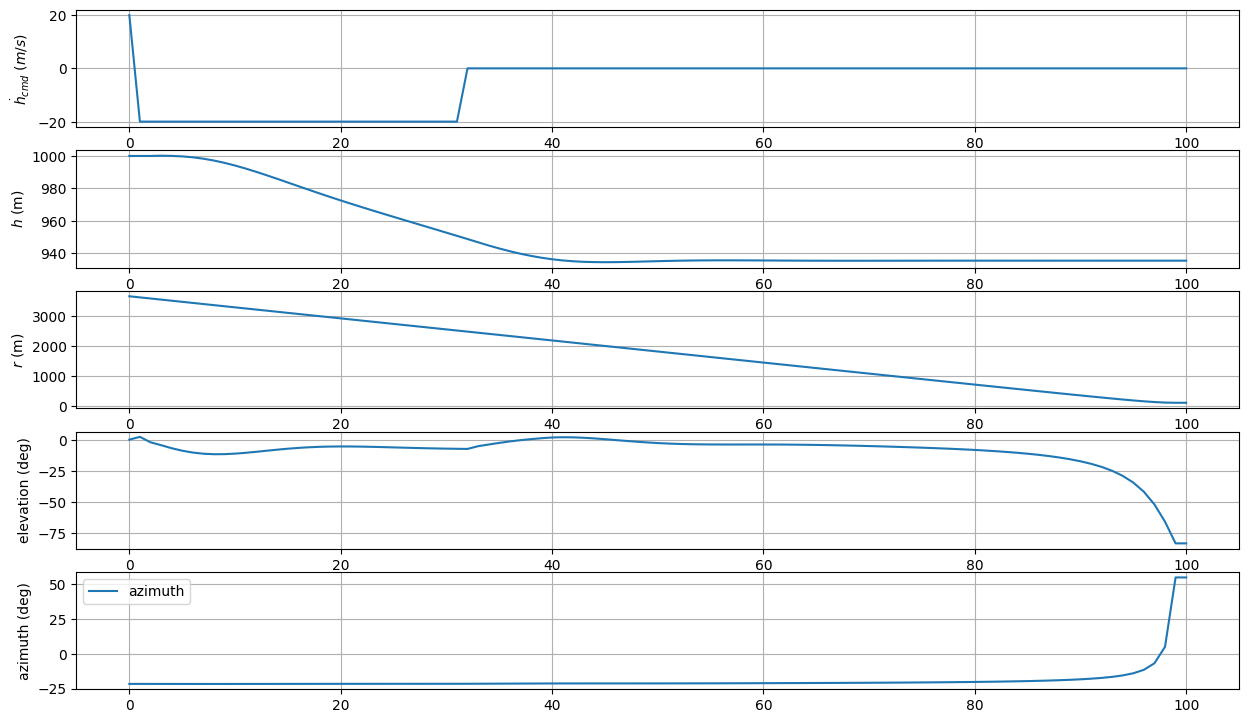

In [10]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[-1]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

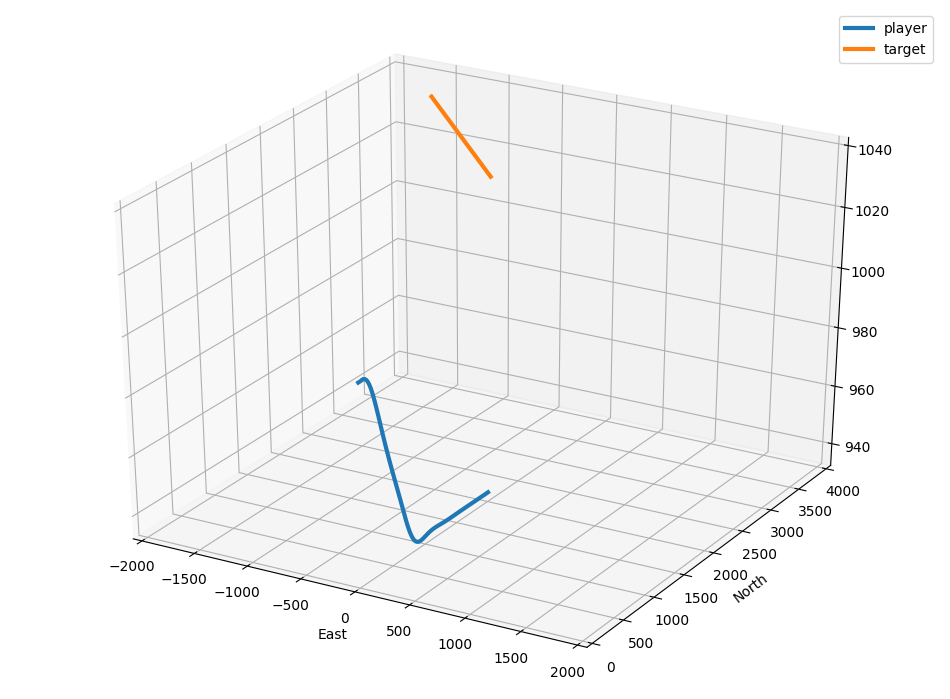

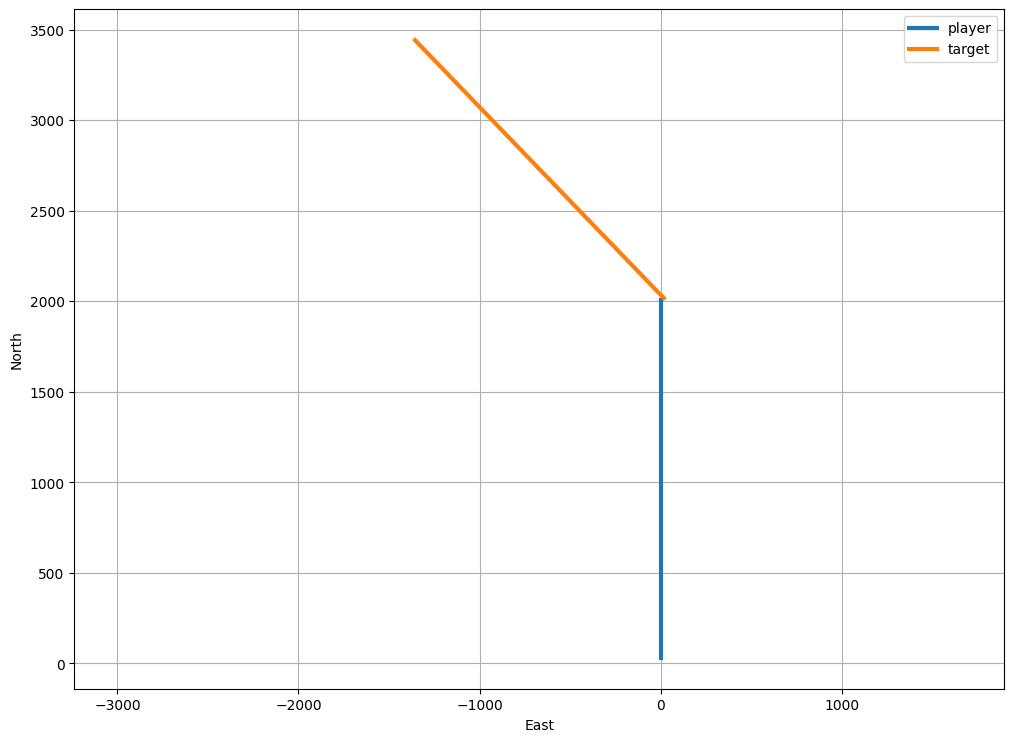

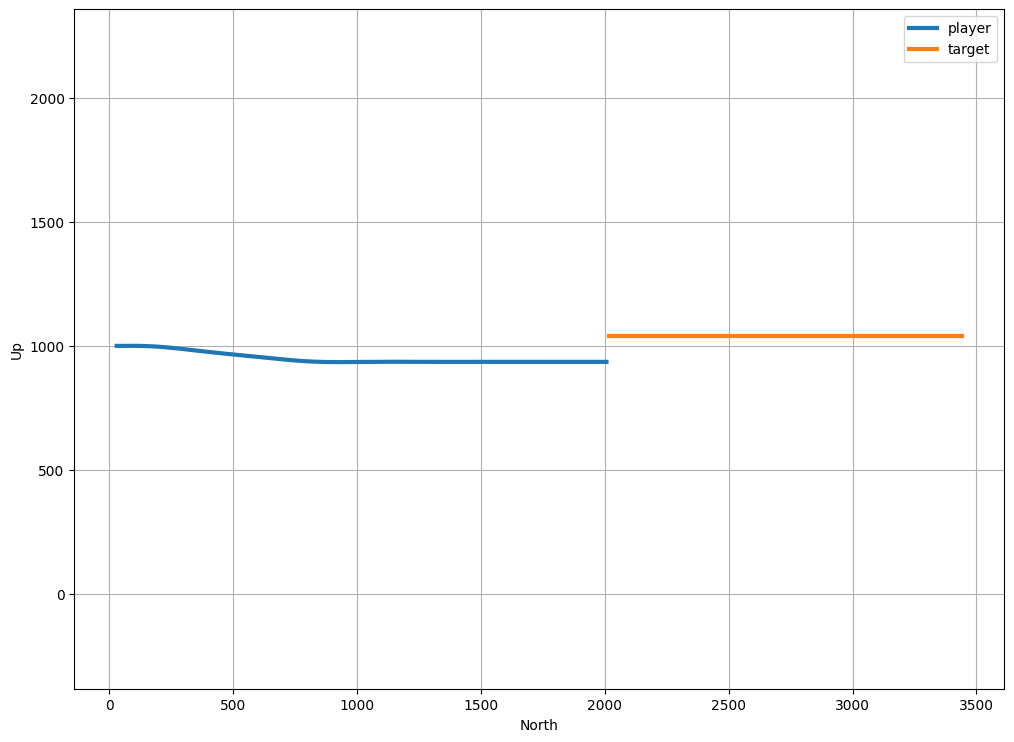

In [11]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()